# Задача
Добиться хорошего результата от модели, собранной на занятии (5 угаданныx картинок из 8 предложенных). Варианты изменений:
- изменение слоёв и их количества;
- изменение метода оптимизации;
- изменение процесса обучения;
- *преобразование данных transform

In [1]:
# Сделаем необходимые импорты
import torch
from torch import optim
import torch.nn.functional as F
from torch.nn import Linear, CrossEntropyLoss, Module, Dropout, BatchNorm1d
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np


In [2]:

train_dataset = CIFAR10(root='./dataset10',
                         train=True,
                         transform=transforms.ToTensor(),
                         download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64,
                                           shuffle=True)
test_dataset = CIFAR10(root='./dataset10', train=False,
                       download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                          shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [3]:
image, label = train_dataset[50]
print(len(train_loader))
print(image.size())
print(label)


782
torch.Size([3, 32, 32])
9


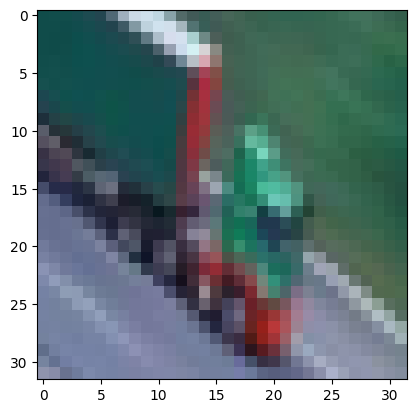

In [4]:
plt.imshow(image.permute(1, 2, 0).numpy())
plt.show()

In [29]:
# Создайте собственную архитектуру! Можете использовать все, что угодно, 
# но в ограничении на использование линейные слои (пока без сверток)
# Давайте добавим ограниченный Leaky_relu, то есть output = max(0.1x, 0.5x)
# Ваша задача добавить его в архитектуру сети как функцию активации
class Net(Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = Linear(input_dim, 6 * hidden_dim)
        self.fc2 = Linear(6 * hidden_dim, 4 * hidden_dim)
        self.fc3 = Linear(4 * hidden_dim, 2 * hidden_dim)
        self.fc4 = Linear(2 * hidden_dim, hidden_dim)
        self.fc5 = Linear(hidden_dim, output_dim)
# ? Переопределение?
#  В какой момент вызывается?
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.leaky_relu(x, 0.05)
        x = self.fc2(x)
        x = F.leaky_relu(x, 0.05)
        x = self.fc3(x)
        x = F.leaky_relu(x, 0.05)
        x = self.fc4(x)
        x = F.leaky_relu(x, 0.05)
        x = self.fc5(x)
        x = F.softmax(x, dim=1)
        return x

In [30]:
net = Net(3072, 100, 10).cuda()

In [35]:
# Запустить обучение (по аналогии с тем, что делали на паре)
net.train()
epochs = 100
criterion = CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
for epoch in tqdm(range(epochs)):  
    running_loss = 0.0
    # ? Subscrable
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].cuda(), data[1].cuda()

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        if not (i % 200) and i != 0:    # печатаем каждые 300 mini-batches
        # ? Почему не running_loss / len(running_loss)
            print(f'[{epoch + 1}, {(i + 1):5d}] loss: {(running_loss / 200):.3f}')
            running_loss = 0.0

print('Training is finished!')

  0%|          | 0/100 [00:00<?, ?it/s]

[1,   201] loss: 2.374
[1,   401] loss: 2.356
[1,   601] loss: 2.361


  1%|          | 1/100 [00:10<17:18, 10.49s/it]

[2,   201] loss: 2.377
[2,   401] loss: 2.361
[2,   601] loss: 2.360


  2%|▏         | 2/100 [00:21<17:11, 10.52s/it]

[3,   201] loss: 2.376
[3,   401] loss: 2.360
[3,   601] loss: 2.360


  3%|▎         | 3/100 [00:31<17:06, 10.59s/it]

[4,   201] loss: 2.372
[4,   401] loss: 2.358
[4,   601] loss: 2.362


  4%|▍         | 4/100 [00:42<17:02, 10.65s/it]

[5,   201] loss: 2.372
[5,   401] loss: 2.357
[5,   601] loss: 2.367


  5%|▌         | 5/100 [00:53<16:51, 10.64s/it]

[6,   201] loss: 2.368
[6,   401] loss: 2.364
[6,   601] loss: 2.363


  6%|▌         | 6/100 [01:03<16:28, 10.51s/it]

[7,   201] loss: 2.374
[7,   401] loss: 2.359
[7,   601] loss: 2.360


  7%|▋         | 7/100 [01:13<16:13, 10.47s/it]

[8,   201] loss: 2.369
[8,   401] loss: 2.358
[8,   601] loss: 2.362


  8%|▊         | 8/100 [01:24<16:02, 10.46s/it]

[9,   201] loss: 2.374
[9,   401] loss: 2.362
[9,   601] loss: 2.359


  9%|▉         | 9/100 [01:34<15:54, 10.49s/it]

[10,   201] loss: 2.369
[10,   401] loss: 2.360
[10,   601] loss: 2.366


 10%|█         | 10/100 [01:45<15:43, 10.49s/it]

[11,   201] loss: 2.373
[11,   401] loss: 2.359
[11,   601] loss: 2.364


 11%|█         | 11/100 [01:55<15:32, 10.48s/it]

[12,   201] loss: 2.374
[12,   401] loss: 2.361
[12,   601] loss: 2.359


 12%|█▏        | 12/100 [02:06<15:21, 10.47s/it]

[13,   201] loss: 2.376
[13,   401] loss: 2.358
[13,   601] loss: 2.362


 13%|█▎        | 13/100 [02:16<15:18, 10.55s/it]

[14,   201] loss: 2.372
[14,   401] loss: 2.366
[14,   601] loss: 2.359


 14%|█▍        | 14/100 [02:27<15:12, 10.61s/it]

[15,   201] loss: 2.372
[15,   401] loss: 2.364
[15,   601] loss: 2.358


 15%|█▌        | 15/100 [02:38<14:57, 10.56s/it]

[16,   201] loss: 2.372
[16,   401] loss: 2.362
[16,   601] loss: 2.362


 16%|█▌        | 16/100 [02:48<14:43, 10.52s/it]

[17,   201] loss: 2.371
[17,   401] loss: 2.361
[17,   601] loss: 2.366


 17%|█▋        | 17/100 [02:58<14:29, 10.48s/it]

[18,   201] loss: 2.372
[18,   401] loss: 2.362
[18,   601] loss: 2.361


 18%|█▊        | 18/100 [03:09<14:24, 10.55s/it]

[19,   201] loss: 2.371
[19,   401] loss: 2.363
[19,   601] loss: 2.362


 19%|█▉        | 19/100 [03:20<14:20, 10.62s/it]

[20,   201] loss: 2.375
[20,   401] loss: 2.361
[20,   601] loss: 2.358


 20%|██        | 20/100 [03:30<14:06, 10.58s/it]

[21,   201] loss: 2.370
[21,   401] loss: 2.360
[21,   601] loss: 2.363


 21%|██        | 21/100 [03:41<14:03, 10.67s/it]

[22,   201] loss: 2.369
[22,   401] loss: 2.365
[22,   601] loss: 2.362


 22%|██▏       | 22/100 [03:52<13:59, 10.76s/it]

[23,   201] loss: 2.374
[23,   401] loss: 2.360
[23,   601] loss: 2.362


 23%|██▎       | 23/100 [04:03<13:47, 10.74s/it]

[24,   201] loss: 2.368
[24,   401] loss: 2.362
[24,   601] loss: 2.365


 24%|██▍       | 24/100 [04:14<13:38, 10.77s/it]

[25,   201] loss: 2.372


In [8]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [27]:
net.eval()
stop = 5
verifi = 0
for k, data in enumerate(test_loader):
    inputs, labels = data[0].cuda(), data[1]
    pred = net(inputs).cpu()
    pred = pred.detach().numpy()
    labels = labels.numpy()
    for j, i in enumerate(pred):
        ind_p = np.argmax(i)
        ind_r = labels[j]
        if ind_p == ind_r:
            verifi += 1
        print(f'Предсказано: {classes[ind_p]}\nРеально: {classes[ind_r]}\n')
    if k == stop:
        break
print(f'Из {(stop + 1) * 4} угадано {verifi}' )


Предсказано: cat
Реально: cat

Предсказано: truck
Реально: ship

Предсказано: ship
Реально: ship

Предсказано: plane
Реально: plane

Предсказано: deer
Реально: frog

Предсказано: frog
Реально: frog

Предсказано: cat
Реально: car

Предсказано: frog
Реально: frog

Предсказано: dog
Реально: cat

Предсказано: car
Реально: car

Предсказано: ship
Реально: plane

Предсказано: truck
Реально: truck

Предсказано: cat
Реально: dog

Предсказано: horse
Реально: horse

Предсказано: truck
Реально: truck

Предсказано: ship
Реально: ship

Предсказано: dog
Реально: dog

Предсказано: truck
Реально: horse

Предсказано: ship
Реально: ship

Предсказано: frog
Реально: frog

Предсказано: horse
Реально: horse

Предсказано: plane
Реально: plane

Предсказано: plane
Реально: deer

Предсказано: truck
Реально: truck

Из 24 угадано 16
